In [1]:
import numpy as np
import numpy.linalg as linalg
import math
import matplotlib.pyplot as plt

### Kernel function (+helper function for covariance matrix)

In [2]:
def squared_exp(x_p, x_q, l):
    r = x_p - x_q
    return np.exp(-(r**2 / (2 * (l**2))))

In [3]:
def comp_cov(x1, x2, l=0.5):
    #because float objects are not iterable
    if type(x1) == float:
        x1 = np.array([x1])
    if type(x2) == float:
        x2 = np.array([x2])
    
    cov = []
    for i in x1:
        col = []
        for j in x2:
            col.append(squared_exp(i, j, l))
        cov.append(col)
    return np.array(cov)

#### Training Data

In [4]:
X = np.array([0.5, 1.1, 1.7, 2.3, 2.9, 3.5, 4.1, 4.7])
y = np.array([2.3, 1.9, 3.3, 5.5,  3.1, 9.1, 7.8, 7.8])

### Gaussian Process Prediction algorithm

In [5]:
def pred(X, y, k, o, x_s, l=0.5):
    K = k(X, X, l)
    L = linalg.cholesky(K + (o**2)*np.identity(len(K)))
    a = linalg.solve(L.T, linalg.solve(L, y))
    f = []
    V = []
    try:
        for x_ss in x_s:
            if type(x_ss) != np.array or type(x_ss) != numpy.ndarray:
                x_ss = np.array([x_ss])

            k_s = k(X, x_ss, l)
            f.append(k_s.T@a)
            v = linalg.solve(L, k_s)

            V.append(np.squeeze(k(x_ss, x_ss)) - v.T@v)
    except:
        k_s = k(X, x_s, l)
        f.append(k_s.T@a)
        v = linalg.solve(L, k_s)
        V.append(np.squeeze(k(x_s, x_s)) - v.T@v)
        
    logp = (-1/2)*y.T@a - np.trace(L) - len(L)/2 * np.log(2*np.pi)
    return np.squeeze(f), np.squeeze(V) #getting rid of arbitrary dimensions (i.e. [[x]])

In [6]:
mean, var = pred(X, y, comp_cov, 0.2, 3.4)

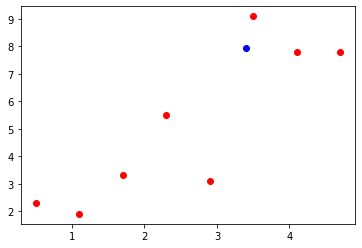

In [7]:
plt.plot(X, y, 'ro')
plt.plot(3.4, mean, 'bo')

#### A few results

In [8]:
def plot(X_train, y_train, X_test, y_pred, variance):
    fig, ax = plt.subplots(1, 1)
    ax.plot(X_train, y_train, 'ro')
    ax.plot(X_test, y_pred)
    ax.fill_between(X_test, y_pred+ (2*np.sqrt(variance)), y_pred-(2*np.sqrt(variance)), facecolor='gray', alpha=0.4)
    return ax

In [9]:
X_test = np.linspace(0.5, 5, 100)
means, variance = pred(X, y, comp_cov, 0.2, X_test, 1.5) #"good" result
means_over, variance_over = pred(X, y, comp_cov, 0.1, X_test, 0.2) #overfitting parameters
means_under, variance_under = pred(X, y, comp_cov, 2, X_test, 3) #udnerfitting parameters

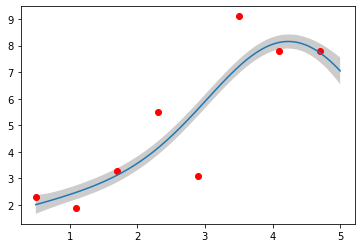

In [10]:
plot(X, y, X_test, means, variance)

### Overfitting example

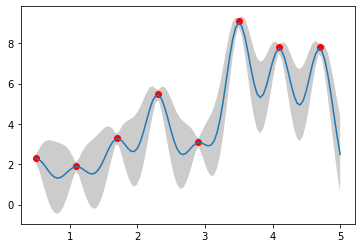

In [11]:
plot(X, y, X_test, means_over, variance_over)

### Underfitting example

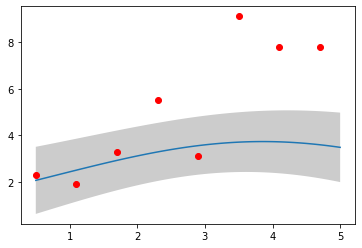

In [12]:
plot(X, y, X_test, means_under, variance_under)

# Example predicting sine wave
---

###### Preparing Sine Train Data with noise

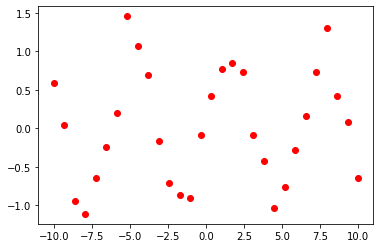

In [13]:
X_sin = np.linspace(-10, 10, 30);

y_sin = np.random.normal(np.sin(X_sin),0.2) #sine wave with noise

plt.plot(X_sin, y_sin, 'ro')

In [14]:
X_test_sin = np.linspace(-10, 10, 100);

In [15]:
means_sin, variance_sin = pred(X_sin, y_sin, comp_cov, 0.2, X_test_sin, 1.5)

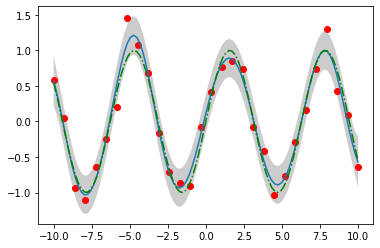

In [16]:
ax = plot(X_sin, y_sin, X_test_sin, means_sin, variance_sin) #train points + prediction + confidence band
ax.plot(X_test_sin, np.sin(X_test_sin), 'g-.') #actual sine wave

In [17]:
from sklearn.metrics import r2_score

In [18]:
r2_score(np.sin(X_test_sin), means_sin)

0.984286294005881

###### variance outside of train data:

In [19]:
X_test_sin_expanded = np.linspace(-14, 14, 100);

In [20]:
means_expanded, variance_expanded = pred(X_sin, y_sin, comp_cov, 0.2, X_test_sin_expanded, 1.5)

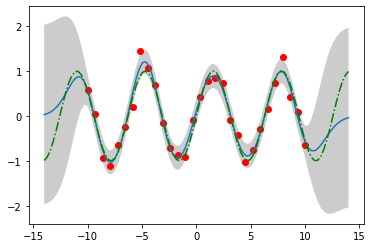

In [21]:
ax = plot(X_sin, y_sin, X_test_sin_expanded, means_expanded, variance_expanded)
ax.plot(X_test_sin_expanded, np.sin(X_test_sin_expanded), 'g-.')